In [1]:
using SLMTools, Images, FreeTypeAbstraction, FileIO, Plots
using SLMTools: wrap

In [2]:
include("../src/SubImages.jl")

handAnnotate (generic function with 4 methods)

In [3]:
N = 128
L0 = natlat((N,N))

(-5.65685424949238:0.08838834764831843:5.568465901844061, -5.65685424949238:0.08838834764831843:5.568465901844061)

Intensity, modulus, phase:


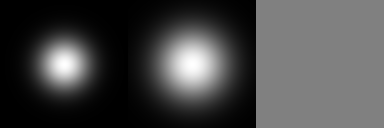

In [4]:
# Generate input beam
I = LF{ComplexAmp}( exp.(-r2(L0) ./ (3 + 0im)^2) , L0 )
println("Intensity, modulus, phase:")
look(square(I),I)

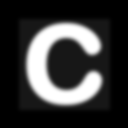

In [5]:
# Generate target intensity
C = lfRect(I|>square,(4,4))*0.1 + lfText(Intensity,"c"; lfTemplate=I, pixelsize=150)    # Letter c on low background
C = LF{Intensity}(imfilter(C.data, Kernel.gaussian(2)),C.L)                             # Blur the edges slightly
look(C)

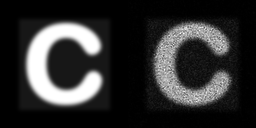

In [6]:
Φgs = gs(abs(I),sqrt(C),10000,wrap(LF{RealPhase}(rand(size(C)...),C.L)))    # Generate phase w/ GS + random initialization
look(C,square(sft(I * Φgs)))

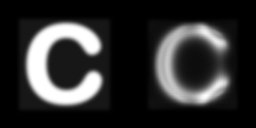

In [7]:
Φot = otPhase(square(I),C,0.001)     # Generate phase w/ OT
look(C,square(sft(I * Φot)))

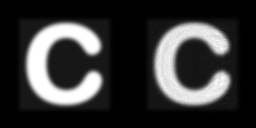

In [8]:
Φotgs = gs(abs(I),sqrt(C),10000,wrap(Φot))    # Generate phase w/ GS + OT initialization
look(C,square(sft(I * Φotgs)))

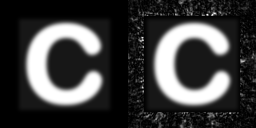

In [9]:
Φotmraf = mraf(abs(I),sqrt(C),10000,wrap(Φot),CartesianIndices((17:112,17:112)),0.48)
look(C,square(sft(I * Φotmraf)))

In [10]:
# Evaluate RMS error for each phase
for Φ in [Φgs,Φot,Φotgs,Φotmraf]
    println(SchroffError(C,square(sft(abs(I) * Φ))))
end

0.14813186969549982
0.17376155397833687
0.0273470904731181
5.465265329226124e-16


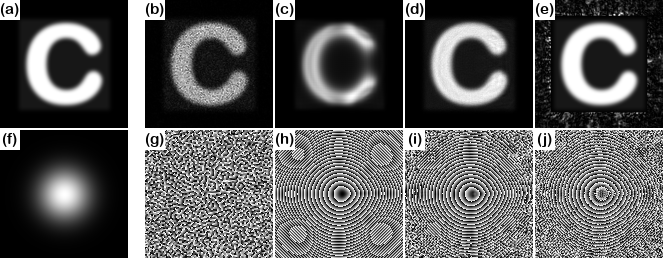

In [11]:
# Merge images
phases = [Φgs,Φot,Φotgs,Φotmraf]
outbeams = [square(sft(abs(I) * Φ)) for Φ in phases];
anns = handAnnotate(look.([C outbeams... ; square(I) phases...]), 
    ("(a)","(f)","(b)","(g)","(c)","(h)","(d)","(i)","(e)","(j)"),15,(20,20))
anns[:,1] = padadd.(anns[:,1],15,:r,1)
fig = mergeStrict(anns; padright = 2, padbottom=2, fillval=1)